In [1]:
import os
import matplotlib.pyplot as plt
import h5py
import phase_contrast as pc
from pathlib import Path
import numpy as np
from PIL import Image

In [10]:
SCRIPT_PATH = os.getcwd()
PHANTOM_DB_FOLDER_NAME = 'database'
TXT_FOULDER_NAME = 'txt_files'

In [3]:
def get_img(file_name):
    file_path = os.path.join(SCRIPT_PATH, PHANTOM_DB_FOLDER_NAME, file_name)

    with h5py.File(file_path, 'r') as hdf:
        dataset = hdf.get(name = file_name)
        dataset = dataset[()]
    return dataset

In [5]:
def get_2d_slice(num):
    data_folder = '/nfs/synology-tomodata/external_data/tomo/Diamond/I13'+\
                    '/2020_02/recon/123495/full_recon/20200206141126_123495/TiffSaver-tomo'

    file_names = Path(data_folder).glob('*.tiff')
    file_names = list(file_names)
    img2d_gray = img2d = np.array(Image.open(file_names[num]))

    return img2d_gray

In [25]:
def write_dict_to_file(dict):
    for key, value in dict.items():
        write_item_to_file(key, value)


def write_item_to_file(key, value):
    db_folder = os.path.join(SCRIPT_PATH, TXT_FOULDER_NAME)
    if not os.path.isdir(db_folder):
        os.mkdir(db_folder)

    file_path = os.path.join(SCRIPT_PATH, TXT_FOULDER_NAME, 'k_values.txt')
    file_txt = open(file_path,"a")
    file_txt.write(f"{key} {value} \n")
    file_txt.close()


dictionary = {'1': 10, '20': 2000}
write_dict_to_file(dictionary)

In [26]:
k_dictionary ={}

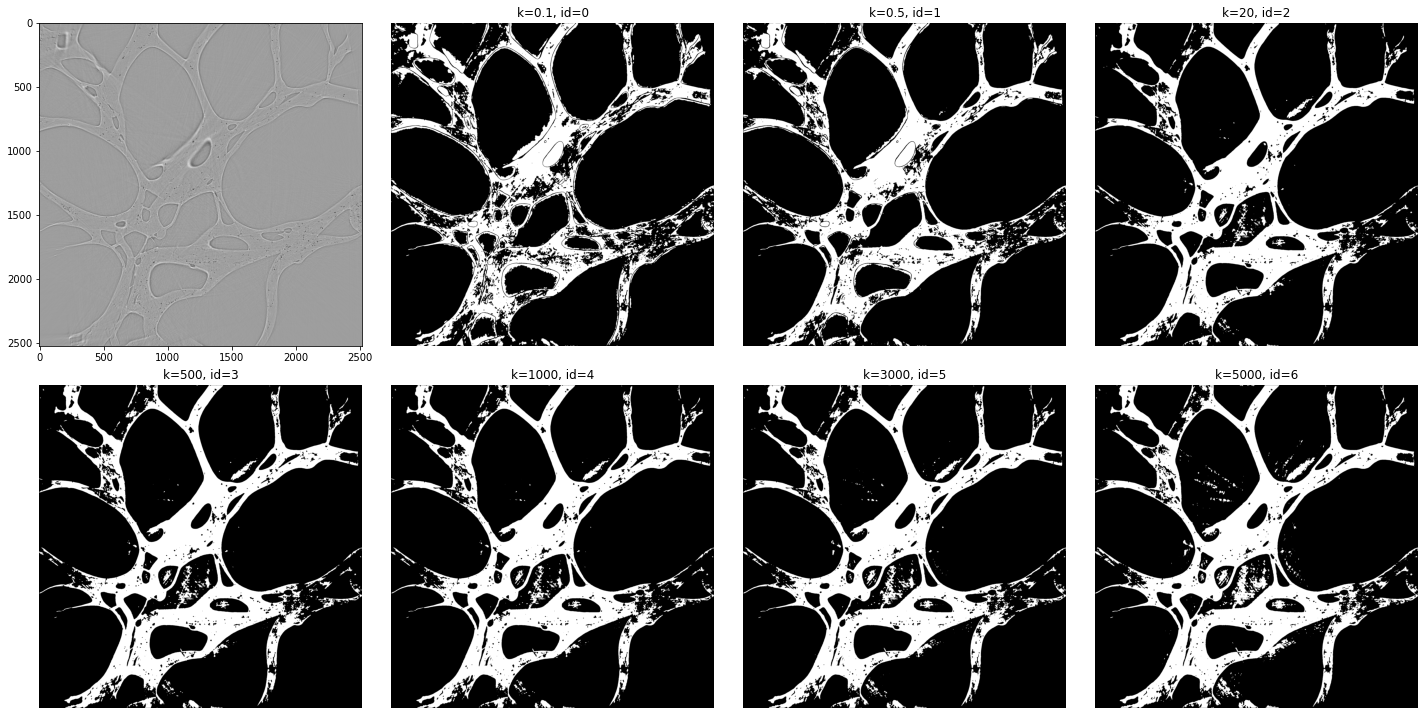

In [47]:
k_possible_values = [1/10, 1/2, 20, 500, 1000, 3000, 5000]
slice_num = 90
k = k_possible_values[0]

img2d_gray = get_2d_slice(slice_num)
fig, axes = plt.subplots(2, 4, figsize=(20,10))

axes = axes.ravel()
axes[0].imshow(img2d_gray, cmap='gray')

for i, k in enumerate(k_possible_values):
    axes[i+1].imshow(pc.binarize_slice(img2d_gray, k=k, mu=25e-8), cmap='gray')
    axes[i+1].set_title(f"k={k}, id={i}")
    axes[i+1].axis("off")

plt.tight_layout()

In [48]:
id = 3
k_dictionary.update({f"{slice_num}": k_possible_values[id]})

In [49]:
# backup
write_dict_to_file(k_dictionary)
k_dictionary = {}

# RESULTS

29

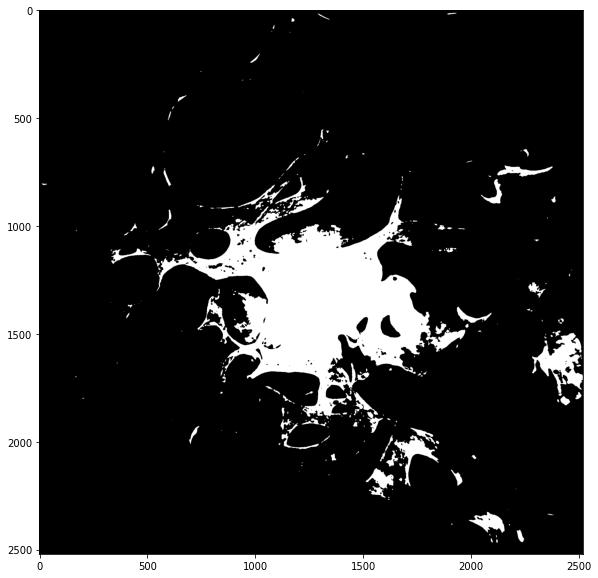

In [86]:
data_folder = '/nfs/synology-tomodata/external_data/tomo/Diamond/I13'+\
                '/2020_02/recon/123495/full_recon/20200206141126_123495/TiffSaver-tomo'


num = np.random.randint(0,100)
img3d = get_img(f'test_file{1}.h5')
fig, axes = plt.subplots(figsize=(10,10))
axes.imshow(img3d[num], cmap='gray')
num